In [1]:
import os
import sys

os.chdir('../')
sys.path.append("Marigold")

In [2]:
import torch
from marigold.repaint_pipeline import MariogldRepaintPipeline

In [3]:
pipe = MariogldRepaintPipeline.from_pretrained("Bingxin/Marigold", torch_dtype=torch.float32)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
from torchvision import transforms

denoise_steps=100
ensemble_size=10
processing_res=768
match_input_res=True
batch_size=0
color_map="Spectral"

data_path = "/data2/wlsgur4011/SparseDC/datas/cache/1.marigold(vanilla)_a8b9d00ddfebe9d72ec8a22fdb190230.pt"
data = torch.load(data_path)
my_image_tensor = data['rgb'][0].cuda()
image = transforms.ToPILImage()(my_image_tensor)
depth_gt_sparse = data["dep"][0][0].cuda()

pipe_out = pipe(
    image,
    denoising_steps=denoise_steps,
    ensemble_size=ensemble_size,
    processing_res=processing_res,
    match_input_res=match_input_res,
    batch_size=batch_size,
    color_map=color_map,
    show_progress_bar=True,
    depth_gt_sparse=depth_gt_sparse,
    jump_n_sample=2.
)

1111  "monocular depth estimation"
2222  "rescale gt sparse depth"
2222  "tensor[359] 1.4Kb x∈[0.001, 1.000] μ=0.247 σ=0.251 cuda:0"
3333  "prepare dataloader (but bs is fixed to 1)"


  Inference batches:   0%|          | 0/1 [00:00<?, ?it/s]

4444  "sparse guided depth estimation"


    Diffusion denoising:   0%|          | 0/298 [00:00<?, ?it/s]

3333  "tensor[359] 1.4Kb x∈[0.001, 1.000] μ=0.247 σ=0.251 cuda:0"
3333  "tensor[359] 1.4Kb x∈[0.001, 1.000] μ=0.247 σ=0.251 cuda:0"
3333  "tensor[359] 1.4Kb x∈[0.001, 1.000] μ=0.247 σ=0.251 cuda:0"
3333  "tensor[359] 1.4Kb x∈[0.001, 1.000] μ=0.247 σ=0.251 cuda:0"
3333  "tensor[359] 1.4Kb x∈[0.001, 1.000] μ=0.247 σ=0.251 cuda:0"
3333  "tensor[359] 1.4Kb x∈[0.001, 1.000] μ=0.247 σ=0.251 cuda:0"
3333  "tensor[359] 1.4Kb x∈[0.001, 1.000] μ=0.247 σ=0.251 cuda:0"
3333  "tensor[359] 1.4Kb x∈[0.001, 1.000] μ=0.247 σ=0.251 cuda:0"
3333  "tensor[359] 1.4Kb x∈[0.001, 1.000] μ=0.247 σ=0.251 cuda:0"
3333  "tensor[359] 1.4Kb x∈[0.001, 1.000] μ=0.247 σ=0.251 cuda:0"
3333  "tensor[359] 1.4Kb x∈[0.001, 1.000] μ=0.247 σ=0.251 cuda:0"
3333  "tensor[359] 1.4Kb x∈[0.001, 1.000] μ=0.247 σ=0.251 cuda:0"
3333  "tensor[359] 1.4Kb x∈[0.001, 1.000] μ=0.247 σ=0.251 cuda:0"
3333  "tensor[359] 1.4Kb x∈[0.001, 1.000] μ=0.247 σ=0.251 cuda:0"
3333  "tensor[359] 1.4Kb x∈[0.001, 1.000] μ=0.247 σ=0.251 cuda:0"
3333  "ten

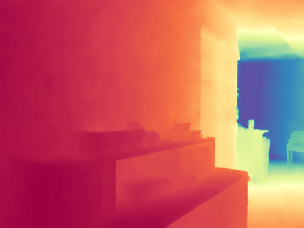

In [6]:
pipe_out['depth_colored']

In [7]:
%matplotlib inline

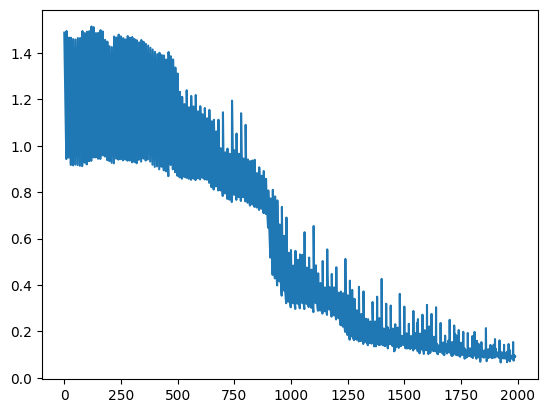

In [8]:
import matplotlib.pyplot as plt

loss_log = pipe.repaint_scheduler.loss_log
plt.plot(range(len(loss_log)), loss_log)
# plt.ylim(0, 1.7)
plt.show()

In [9]:
import jhutil; jhutil.jhprint(1111, pipe_out)

1111  {
    "depth_np": "array[228, 304] f32 n=69312 (0.3Mb) x∈[1.021, 6.704] μ=2.355 σ=1.530",
    "depth_colored": "<PIL.Image.Image image mode=RGB size=304x228 at 0x7F6FA5B99760>",
    "uncertainty": null
}


In [10]:
depth_guided = torch.tensor(pipe_out['depth_np'])

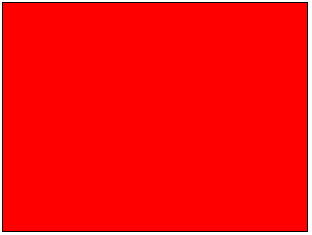

In [11]:
depth_guided.chans

In [12]:
depth_gt = data['gt'][0][0]
import jhutil; jhutil.jhprint(1111, depth_guided)
import jhutil; jhutil.jhprint(2222, depth_gt_sparse)
import jhutil; jhutil.jhprint(3333, depth_gt)

1111  "tensor[228, 304] n=69312 (0.3Mb) x∈[1.021, 6.704] μ=2.355 σ=1.530"
2222  "tensor[228, 304] n=69312 (0.3Mb) x∈[0., 6.848] μ=0.013 σ=0.201 cuda:0"
3333  "tensor[228, 304] n=69312 (0.3Mb) x∈[1.000, 7.159] μ=2.408 σ=1.605 cuda:0"


In [13]:

from src.utils.depth_utils import compute_scale_and_shift
# from src.utils.depth_utils import get_diff_depth

def get_diff_depth(depth_pred, depth_gt_sparse, depth_gt):
    if depth_pred.ndim == 3:
        depth_pred = depth_pred.squeeze(0)
    if depth_gt_sparse.ndim == 3:
        depth_gt_sparse = depth_gt_sparse.squeeze(0)
    if depth_gt.ndim == 3:
        depth_gt = depth_gt.squeeze(0)

    mask = depth_gt_sparse != 0
    scale, shift = compute_scale_and_shift(depth_pred[None, :], depth_gt_sparse[None, :], mask[None, :])
    scaled_depth = scale * depth_pred + shift

    diff_depth = scaled_depth - depth_gt

    return diff_depth

depth_diff = get_diff_depth(depth_guided.cuda(), depth_gt_sparse.cuda(), depth_gt.cuda())

In [14]:

import jhutil; jhutil.jhprint(1111, depth_diff.abs())

1111  "tensor[228, 304] n=69312 (0.3Mb) x∈[2.384e-07, 3.010] μ=0.121 σ=0.173 cuda:0"


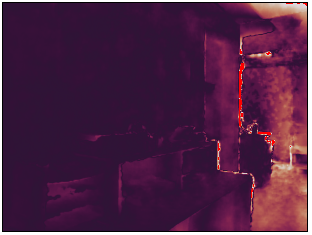

In [ ]:
depth_diff.abs().chans